In [1]:
import xarray as xr
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sc
import torch
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import torch.utils.data as data_utils
from torch.nn import Linear
from torch.functional import F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from tqdm import tqdm

import matplotlib.pyplot as plt
import csv

from itertools import combinations, permutations

In [2]:
torch.manual_seed(21985)
np.random.seed(21985)

In [18]:
# Data from Sean's version of Hugh's Tau model
path = 'singlecatdata'
ncfile = 'offline_79micron_referencedetail.nc'

ncfilepath=os.path.join(path,ncfile)

nc=xr.open_dataset(ncfilepath)

nc['ccoal'].stack(y=('altitude','case','time'))

nc

<xarray.Dataset>
Dimensions:                        (altitude: 20, bin_edge_mass: 36, bin_mass: 35, case: 16, cloud_moment: 3, rain_moment: 3, time: 721)
Coordinates:
  * altitude                       (altitude) float64 0.0 100.0 ... 1.9e+03
  * time                           (time) float64 0.0 5.0 ... 3.595e+03 3.6e+03
  * cloud_moment                   (cloud_moment) int32 0 3 6
  * rain_moment                    (rain_moment) int32 0 3 6
  * bin_mass                       (bin_mass) float64 2.397e-14 ... 0.0004118
  * bin_edge_mass                  (bin_edge_mass) float64 1.598e-14 ... 0.00...
Dimensions without coordinates: case
Data variables: (12/39)
    nccn                           (case) float64 ...
    rhinit                         (case) float64 ...
    lhflux                         (case) float64 ...
    ampw                           (case) float64 ...
    tperiod                        (case) float64 ...
    pressure                       (case, altitude) float64 ...
    ...                             ...
    total_precipitation_number     (case) float64 ...
    total_precipitation_amount     (case) float64 ...
    first_peak_precipitation_rate  (case) float64 ...
    first_peak_precipitation_time  (case) float64 ...
    dsd_number                     (case, time, altitude, bin_mass) float64 ...
    dsd_mass                       (case, time, altitude, bin_mass) float64 ...

In [4]:
class MicroEmulator(torch.nn.Module):
    def __init__(self,n_inputs=3,n_hidden=50,n_outs=3):
        super(MicroEmulator, self).__init__()
        # Just emulate everything
        
        self.dMdt = Seq(Lin(n_inputs, n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_hidden),
                        ReLU(),Lin(n_hidden,n_outs))
        
    def forward(self, x):
        # As inputs -- env_var = ['nccn','theta','rel_hum','pressure']
        dMdt = self.dMdt(x)     
        #return torch.stack((dM0dt.squeeze(),dM3dt.squeeze(),dM6dt.squeeze()),dim=1)
        return dMdt

In [5]:
class CloudDataset(Dataset):
    def __init__(self,Xdata,Ydata,device):
        self.x = Xdata
        self.y = Ydata
        self.device = device

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.x[idx,:]
        Y = self.y[idx,:]
        
        sample = {'X':torch.from_numpy(X).to(device),'Y':torch.from_numpy(Y).to(device)}

        return sample

In [6]:
def loadtaudata(process, moments_used=[0,1,2,3,4,5,6,7], dMdt_output=[0,1,2,3,4,5,6,7]):
    ### [] process is an integer that indicates which process rate we are interested in fitting
    # 0 - cond/evap, 1 - activation, 2 - collision-coalescence (self-collection), 3 - sedimentation
    # these are the order the processes are applied in the Tau model
    
    ### [] moments_used is a list of the moments that are to be trained on. i.e. [2,3,4] 
    
    proc_rates = ['cevap','act','ccoal','csed']
    #proc_rates = 'ccoal'
    env_var = ['nccn','theta','rel_hum','pressure']
    cloud_params = 'cliq_mom'
    
    ncfilepath=os.path.join(path,ncfile)
    nc=xr.open_dataset(ncfilepath)
    
    proc_rate = proc_rates[process]
    
    rates = nc[proc_rate].stack(y=('altitude','case','time'))
    corrmoments = nc[cloud_params] 
    
    cloud_moments = rates.cloud_moment
    nsamp = len(rates.y)
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
    
    #correct the moments at each time step for the processes applied in Tau up to this process is calculated 
    for i in range(0,process):
        corr_proc_rate = proc_rates[i]
        corrmoments = corrmoments - nc[corr_proc_rate]    
    
    moments = corrmoments.to_dataset(name=cloud_params).stack(y=('altitude','case','time'))

    #Compute rough scaling factors 
    
    #calculates average value of each moment for each nonzero value.
    momscale = []
    for i in range(nmoms):
        matrix = nc[cloud_params][:,moments_used[i],:,:]
        moments_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        momscale.append(moments_mean)
    #print(momscale)

    #calculates average value of dMdt for each nonzero value and centers each distribution.
    dmomscale = []
    for i in range(ndmoms):
        matrix = nc[proc_rate][:,dMdt_output[i],:,:]
        dMdt_mean = abs(np.true_divide(matrix.sum(),(matrix!=0).sum()).item())
        dmomscale.append(dMdt_mean)
    #print(dmomscale)
    
    #hard coded values for moments [0,3,6]
    #momscale = [1e7,1e-6,1e-15]
    #dmomscale = [1e5,1e-24,1e-17]

    #normalizing procedure 
    dMdt = np.zeros((nsamp,ndmoms))
    M = np.zeros((nsamp,nmoms))
    for c in range(ndmoms):
        targetdata = rates.isel(cloud_moment=dMdt_output[c]).to_dataframe()
        #dMdt[:,c] = targetdata[proc_rate].to_numpy()/dmomscale[c]
        dMdt[:,c] = targetdata[proc_rate].to_numpy()
    for c in range(nmoms):
        momentdata = moments.isel(cloud_moment= moments_used[c]).to_dataframe()
        #M[:,c] = momentdata[cloud_params].to_numpy()/momscale[c]
        M[:,c] = momentdata[cloud_params].to_numpy()
    allvars = set(nc.data_vars)
    dropvars = allvars - set(env_var)
    
    nc = nc.drop_vars(dropvars)
    nc = nc.drop_dims(['rain_moment','cloud_moment'])
    
    env = nc.stack(y=('altitude','case','time'))
    env = env.to_dataframe().to_numpy()
    
    #predictors = np.concatenate((M,env),axis=1)
    predictors = M
    targets = dMdt
    
    return predictors,targets

In [12]:
#Defines trim_data, a function for filtering and scaling the data according to our specifications
#after it is generated by load_tau_data(). 

def trim_data(pred, tar, moments_used, dMdt_output, log=False):
    
    nmoms = len(moments_used)
    ndmoms = len(dMdt_output)
        
    ###Masking of Data
    
    #combine pred and tar to a single DataFrame
    df_pred = pd.DataFrame(pred)
    df_tar = pd.DataFrame(tar)
    df = pd.concat([df_pred, df_tar], axis=1)
    
    #gives the dataframe correct column labels (environmental variables are hardcoded for now)
    pred_cols = ['M'+str(3*i-6) for i in moments_used] # + ['nccn', 'pressure', 'theta', 'rel_hum']
    tar_cols = ['dM'+str(3*i-6)+'/dt' for i in dMdt_output]
    df.columns = pred_cols + tar_cols
    
    #remove all datapoints where M0 is less than M0limit and M3 is less than M3limit (not considered a cloud)
    M0limit = 1e-2
    M3limit = 1e-15/(1000.*np.pi/6)
    df = df.drop(df[(df.M0 < M0limit) | (df.M3 < M3limit)].index)
    
    #"clip" all moments to be equal to the minimum value of 5 orders of magnitude beneath the maximum value
    for moment_idx in moments_used:
        mom = 'M'+str(3*moment_idx-6)
        min_threshold = df.loc[:,mom].max()/1e5
        df.loc[df[mom]<min_threshold, mom] = min_threshold
    
    #applies a logarithm to the moment data
    if log:
        for moment_idx in moments_used:
            mom = 'M' + str(3*moment_idx-6)
            df[mom] = np.log10(df[mom])

# Had issues with taking log10 of 0 valued dMX/dt's. 

#         for dmoment_idx in dMdt_output:
#             dmom ='dM' + str(3*dmoment_idx-6)+'/dt'
#             df[dmom] = np.log10(abs(df[dmom]))
        
    df_pred = df[pred_cols].copy()
    df_tar = df[tar_cols].copy()
    
    predfiltered = df_pred.to_numpy()
    tarfiltered = df_tar.to_numpy()
    
    #Scales predictor values to between 0 and 1
    scaler_pred = preprocessing.MinMaxScaler()
    predrescaled = scaler_pred.fit_transform(predfiltered)

    #Scales target values to between 0 and 1
    scaler_tar = preprocessing.MinMaxScaler()
    tarrescaled = scaler_tar.fit_transform(tarfiltered)
    
    return predrescaled, tarrescaled, scaler_pred, scaler_tar

In [13]:
# train, test, inference
def train(model,dataloader,criterion,device, optimizer):
    model.train()
    for data in dataloader:
        X = data['X'].float()
        Y = data['Y'].float()
        #X = X.to(device)
        #Y = Y.to(device)
        out = model(X)
        loss = criterion(out,Y)
        loss.backward()
        optimizer.step()
        #sched.step()
        optimizer.zero_grad()
    return model
def test(model,dataloader,criterion,device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            X = data['X'].float()
            Y = data['Y'].float()
            #X = X.to(device)
            #Y = Y.to(device)
            out = model(X)
            loss = criterion(out,Y)
            correct = correct+loss

        return correct #/len(dataloader.dataset)
def inference(model,loader,device, ndmoms):
    model.eval()
    dataset = loader.dataset
    ntargets = ndmoms
    pred = np.zeros((len(dataset),ntargets))
    real = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0
    for data in enumerate(loader):
        #print(i[0],i[1]['X'].shape)

        X = data[1]['X'].float()
        Y = data[1]['Y'].float()

        #X = X.to(device)
        #Y = Y.to(device)

        out = model(X)
        #print(out.shape)
        bs = out.size(0)
        if out is not(None):
            #assert(Y.shape[0]==20),print(jj)
            #print(i,bs,Y.shape)
            real[jj:jj+bs,:]=Y.cpu().detach().numpy().reshape(bs,ntargets)
            pred[jj:jj+bs,:]=out.cpu().detach().numpy().reshape(bs,ntargets)
            jj=jj+bs
            i = i+1
        else:
            break

    return real,pred

In [14]:
model = torch.load('0-3-6-9_model.pth')

In [16]:
###NN Forward Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

moments = [2,3,4,5]
dMdt_output = moments
nmoms = len(moments)
ndmoms = len(dMdt_output)
pred,tar = loadtaudata(2,moments_used=moments,dMdt_output=moments)

predrescaled, tarrescaled, scaler_pred, scaler_tar = trim_data(pred, tar, moments, moments)

# Split into test, train, val
idx = np.arange(0,predrescaled.shape[0])
selidx = idx #np.random.choice(idx,size=50000)

X_train, X_test, y_train, y_test = train_test_split(predrescaled[selidx,:],tarrescaled[selidx,:],test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25, random_state=42)
#print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

traindataset = CloudDataset(X_train,y_train,device)
valdataset = CloudDataset(X_val,y_val,device)
testdataset = CloudDataset(X_test,y_test,device)

# Check if there is a gpu
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
#print(device)

#collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)) ???
trainloader = DataLoader(traindataset,batch_size=20,shuffle=True,num_workers=0)
valloader = DataLoader(valdataset,batch_size=20,shuffle=True,num_workers=0)
testloader = DataLoader(testdataset,batch_size=20,shuffle=True,num_workers=0)

trainreal,trainpred=inference(model,trainloader,device, ndmoms)
valreal,valpred=inference(model,valloader,device, ndmoms)
testreal,testpred=inference(model,testloader,device, ndmoms)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
plt.subplots_adjust(hspace=0.4)
for i in range(ndmoms):
    ax0 = axs[int(i%4)]
    ax0.set_title('dM'+str(3*dMdt_output[i]-6) +'dt')
    ax0.scatter(trainreal[:,i],trainpred[:,i],s=3,label='Train')
    ax0.scatter(testreal[:,i],testpred[:,i],s=3,label='Test')
    ax0.set_xlabel("True")
    ax0.set_ylabel("Predicted")
    ax0.set_xlim(0,1.1)
    ax0.set_ylim(0,1.1)
    ax0.legend()
plt.savefig('0-3-6-9-log-inference.png')

print(predrescaled.shape)
moment_history = np.empty(shape=(0,nmoms))
model.eval()
start_idx = np.random.randint(0,pred.shape[0])

tendency_signs = [-1, -1, 0, 1, 1, 1, 1, 1]
signs = np.array([tendency_signs[i] for i in moments])

with torch.no_grad():
    X = pred[start_idx] #in untransformed form.
    print('Initial true X value:' + str(X))
    for i in range(50000):
        Xlog = np.log10(X)
        X_scaled = scaler_pred.transform([Xlog])[0]
        tendency = model(torch.Tensor(X_scaled))
        tend_np = tendency.detach().numpy()
        tend_log = scaler_tar.inverse_transform([tend_np])[0]
        tend_true = (10**tend_log)*signs
        X = X + tend_true/5.
        #print('X: ' + str(X))
        #print('Tendency: '+str(tend_true))
        moment_history = np.vstack((moment_history, X))
        
#print(moment_history)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x4 and 8x50)

[0.000e+00 1.000e-04 2.000e-04 ... 9.997e-01 9.998e-01 9.999e-01]
[[0.46404786 0.60049295 0.61568905 0.64127941]]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 8x50)

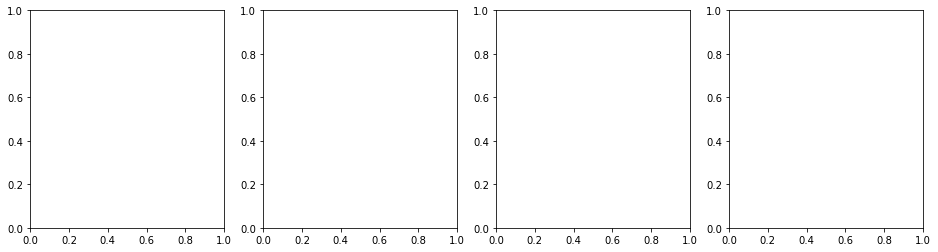

In [11]:
Xvals =  np.arange(0,1,0.0001)
print(Xvals)
print(np.random.rand(1,4)*0.6+0.2)
fig, axs = plt.subplots(1,4, figsize=(16,4))
for j in range(20):
    X = np.random.rand(1,4)
    results = np.empty(shape=(0,4))
    Xtrue = np.empty(shape=(0,4))
    with torch.no_grad():
        for i in range(len(Xvals)):
            X[0] = Xvals[i]
            #print(X)
            out = model(torch.Tensor(X))
            #out = 10**(scaler_tar.inverse_transform([out.numpy()]))[0]
            results = np.vstack((results, out))

            #Xtrue = np.vstack((Xtrue, 10**(scaler_pred.inverse_transform([X]))[0] ))
    #print(results)
    for i in range(4):
        axs[i].plot(Xvals, results[:,i])

        
for i in range(4):
    axs[i].set_xlabel('M0')
    axs[i].set_ylabel('dM' + str(3*i) + '/dt')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(-.5,1.4)

plt.suptitle('Partial Dependence Plots')
plt.tight_layout()
#plt.savefig("pdp.png")
plt.show()


[0.2    0.2001 0.2002 ... 0.7998 0.7999 0.8   ]
[0.8, 0.8, 0.8, 0.8]


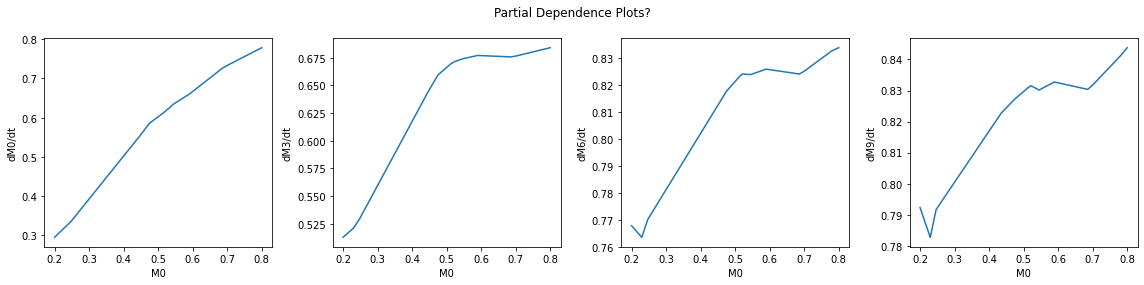

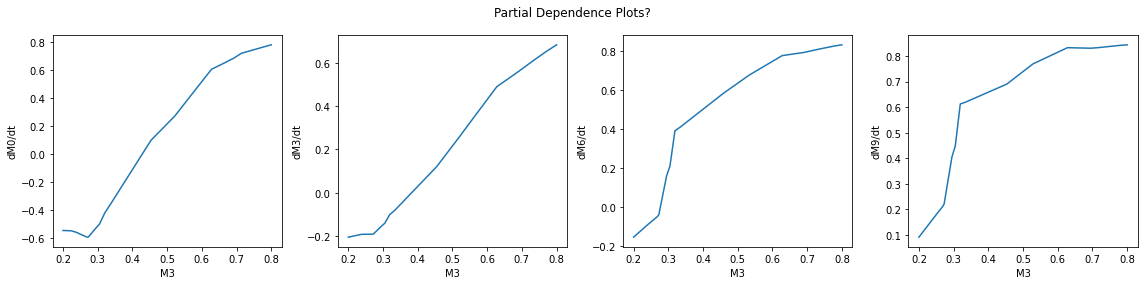

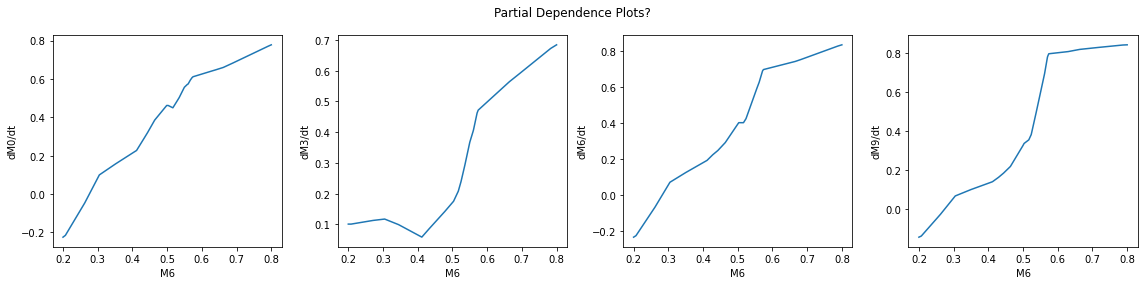

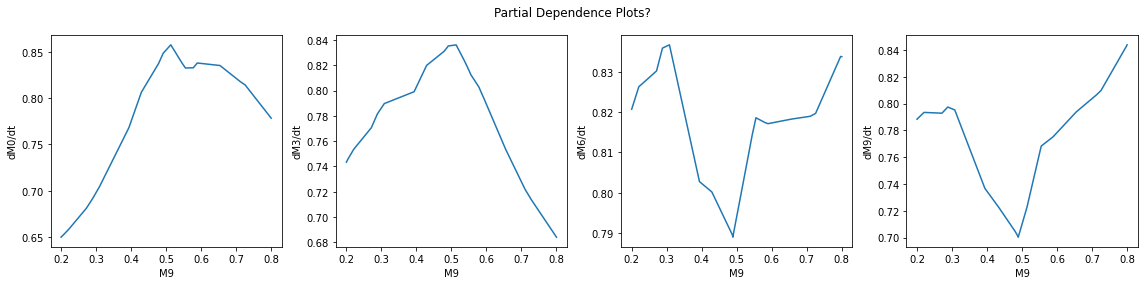

In [119]:
Xvals =  np.arange(0.2,.8,0.0001)
print(Xvals)
X = [0.8, 0.8, 0.8, 0.8]
print(X)
for j in range(4):
    results = np.empty(shape=(0,4))
    Xtrue = np.empty(shape=(0,4))
    with torch.no_grad():
        for i in range(len(Xvals)):
            X[j] = Xvals[i]
            #print(X)
            out = model(torch.Tensor(X))
            #out = 10**(scaler_tar.inverse_transform([out.numpy()]))[0]
            results = np.vstack((results, out))

            Xtrue = np.vstack((Xtrue, 10**(scaler_pred.inverse_transform([X]))[0] ))

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    for i in range(4):
        axs[i].plot(Xvals, results[:,i])
        axs[i].set_xlabel('M' + str(3*j))
        axs[i].set_ylabel('dM' + str(3*i) + '/dt')
        axs[i].set_xlim(0,1.1)
        axs[i].set_ylim(0,1.1)
    plt.suptitle('Partial Dependence Plots')
    plt.tight_layout()
    plt.show()
        

In [20]:
#forward model for Sean's formula-based model

formula_history = np.empty(shape=(0,4))

#starting values of M0 through M9
X_f = pred[start_idx]
M0 = X_f[0]
M3 = X_f[1]
M6 = X_f[2]
M9 = X_f[3]

#params
a_db = -90.647
d3 = 0.15650
b0_k3 = 0.77089
b0_k6 = 0.04616
b6_k3 = 1.5137
b6_k6 = 0.65160
b9_k3 = 2.31716
b9_k6 = 1.50296

#forward modeling
for i in range(1000):
    m = M3 / M0 * (1.e12)
    K3 = np.maximum(M0*M6/M3**2, 1.)
    K6 = np.maximum(M3*M9/M6**2, 1.)
    hyp = np.sqrt(abs(m**2-d3**2)) - d3
    dM0dt = -1*10**(a_db/10.) * M0**2 * hyp * K3**b0_k3 * K6**b0_k6
    dM6dt = 2 * 10**(a_db/10.) * M0**2 * hyp * (1.e-12 * m)**2 * K3**b6_k3 * K6**b6_k6
    dM9dt = 6 * 10**(a_db/10.) * M0**2 * hyp * (1.e-12 * m)**3 * K3**b9_k3 * K6**b9_k6
    M0 = M0 + dM0dt/5.
    M6 = M6 + dM6dt/5.
    M9 = M9 + dM9dt/5.
    formula_history = np.vstack((formula_history, np.array([M0,M3,M6,M9])))

In [21]:
true_history = np.empty(shape=(0,4))
for i in range(start_idx,start_idx+1000):
    true_history = np.vstack((true_history, np.array(pred[i])))

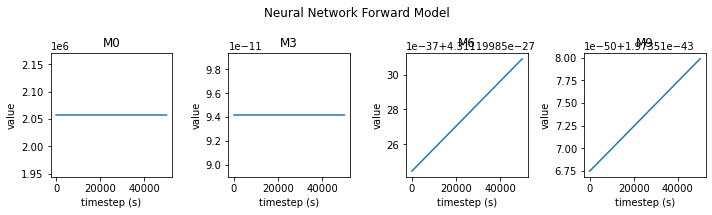

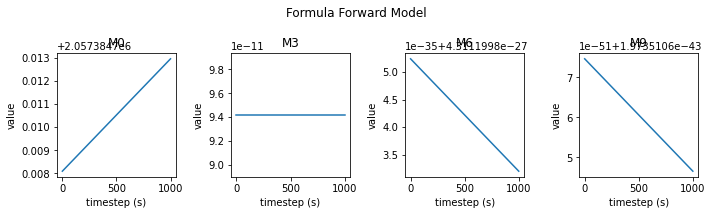

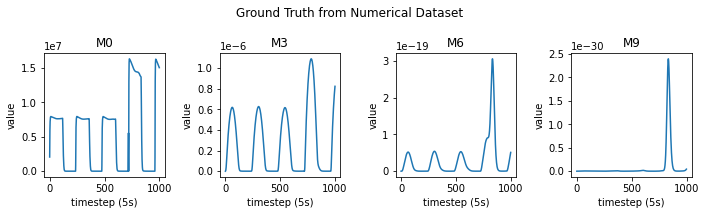

In [29]:
#Neural Network
fig, axs = plt.subplots(1,4,figsize=(10,3))
for i in range(4):
    axs[i].plot(np.arange(0,moment_history.shape[0],1), moment_history[:,i], label=str(3*moments[i]-6))
    axs[i].set_title('M'+str(3*i))
    axs[i].set_xlabel('timestep (s)')
    axs[i].set_ylabel('value')
fig.suptitle('Neural Network Forward Model')
fig.tight_layout()
plt.show()

#Forward Formula
fig,axs = plt.subplots(1,4,figsize=(10,3))
for i in range(4):
    axs[i].plot(np.arange(0,formula_history.shape[0],1), formula_history[:,i], label=str(3*i))
    axs[i].set_title('M' + str(3*i))
    axs[i].set_xlabel('timestep (s)')
    axs[i].set_ylabel('value')
fig.suptitle('Formula Forward Model')
fig.tight_layout()
plt.show()

#Truth
fig,axs = plt.subplots(1,4,figsize=(10,3))
for i in range(4):
    axs[i].plot(np.arange(0,true_history.shape[0],1), true_history[:,i], label=str(3*i))
    axs[i].set_title('M' + str(3*i))
    axs[i].set_xlabel('timestep (5s)')
    axs[i].set_ylabel('value')
fig.suptitle('Ground Truth from Numerical Dataset')
fig.tight_layout()
plt.show()
#plt.savefig('ForwardModelComparison.png')